# Average power spread dependency on spectral window range

This jupyter notebook allows the user to evaluate the behavior of the average power from a power spectrum over all time samples as a function of different spectral windows. This includes plotting the standard deviation and the average of the different time sample's average power. You can also compare all this with a Gaussian noise generated power spectrum.
Every cell before the definitions of functions represent the usual basic code for setting up the data for power spectrum generation. The last cell allows you to plot for many baselines and thus visually compare between them their spread in average power.


In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import scipy
import matplotlib.gridspec as gspec
from scipy.optimize import curve_fit
import math
from matplotlib.ticker import MaxNLocator

In [2]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [3]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# if there is no beam file present, then we can create one

#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [4]:
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')
# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [5]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

The Power_Data function takes in 1 baseline, the minimum and maximum range in the spectral window, and the intervals at which it decreases the spectral window. Thus, for each iterations (spectral window), it generates the uvp object with the power values, and puts in separate lists the power averaged over all time samples, the standard deviation of this average power, the spectral window range and the number of data points present in the range of delay at which we compute the mean and standard deviation.

In [6]:
def Power_Data(baseline,fmin,fmax,spw_jumps):
    
    # Set up the key for the power spectrum data
    key=(0,(baseline,baseline),'xx')
    # Calculate the number of times the spectral window range will be changed
    iterations = int((fmax-fmin)/spw_jumps)
    
    median_power = []
    stan_dev_power = []
    spw_range = []
    delay_quantity = []
    mean_power=[]
    mean_null_power = []
    stan_dev_null_power = []
    median_null_power = []
    MAD = []
    # The -2 is there to avoid generating power spectrums where the spw range is too small.
    for i in range(0,iterations-2):
        
        uvp = ds.pspec([baseline], [baseline], (0, 1), [('xx', 'xx')], spw_ranges=[(fmin,fmax-spw_jumps*i)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=False)
        
        # We calculate the size of the spectral window depending on the number of iterations
        spw_size = fmax-spw_jumps*i-fmin
        power = np.abs(np.real(uvp.get_data(key))).T
        avg_power_delay = np.mean(power[int(2*(spw_size)/3):int(spw_size),:],axis=0)
        
        odd_time_power = power[int(2*(spw_size)/3):int(spw_size),::2]
        even_time_power = power[int(2*(spw_size)/3):int(spw_size),1::2]
        null_power = odd_time_power - even_time_power
        average_null_power = np.mean(null_power,axis=0)
        
        mean_null_power.append(np.mean(average_null_power))
        median_null_power.append(np.median(average_null_power))
        stan_dev_null_power.append(np.std(average_null_power))
        
        median_power.append(np.median(avg_power_delay))
        MAD.append(np.median(np.abs(avg_power_delay-np.median(avg_power_delay))))
        mean_power.append(np.mean(avg_power_delay))
        stan_dev_power.append(np.std(avg_power_delay))
        spw_range.append('('+str(int(uvd.freq_array[0,fmin]/1e5)/10)+'-'+str(int(uvd.freq_array[0,fmax-spw_jumps*i]/1e5)/10)+')')
        delay_quantity.append(int(spw_size)-int(2*(spw_size)/3))
    # We return the data as a list containings lists.
    return [mean_power,stan_dev_power,spw_range,delay_quantity,baseline,median_power,MAD],[mean_null_power,stan_dev_null_power,spw_range,delay_quantity,baseline,median_null_power,MAD]

The Simulated_Gaussian_Noise function basically mimics the power spectrum in the sens that there would be 30 sets of gaussian noise (30 time samples) and a limited number of data points for each (delay axis data points). As in the previous function, it generates the mean and standard deviation based on different sizes for each of these 30 sets of data. Before doing so, it squares the noise so that we are working with its power.

In [7]:
def Simulated_Gaussian_Noise(sigma,mu,delay_quantity):
    
    stan_dev_noise = []
    mean_noise = []
    noise_quantity = []
    
    for quantity in delay_quantity:
        MS=[]
        for time in range(0,30):
            MS.append(np.mean((np.random.normal(mu,sigma,quantity)**2)))
        stan_dev_noise.append(np.std(np.array(MS)))
        mean_noise.append(np.mean(MS))
        noise_quantity.append(quantity)

    return [mean_noise,stan_dev_noise,noise_quantity]

Plot_Results does as the name says. The only not intuitive operation is at the beginning, where the lists containing data are reversed. Its simply because the Power_Data function started with bigger spectral windows, so to plot from smallest to biggest, every lists of data was needed to be reversed like the spectral window list, which corresponds to the x_values_spw.

In [8]:
def Plot_Results(real_data,simulation_data):
    #Unpack the results
    delay_quantity = list(reversed(real_data[3]))
    stan_dev_power = np.array(list(reversed(real_data[1])))
    mean_power = np.array(list(reversed(real_data[0])))
    # We must properly order the spw ranges associated with the correct y values
    x_values_spw = list(reversed(real_data[2]))
    
    baseline = real_data[4]
    
    mean_noise = np.array(list(reversed(simulation_data[0])))
    stan_dev_noise = np.array(list(reversed(simulation_data[1])))
    noise_quantity = list(reversed(simulation_data[2]))
    
    fig = plt.figure(figsize=(14,8))
    gs = gspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[0, 1])
    ax4 = plt.subplot(gs[1, 1])
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    
    # We plot the standard deviation of both the real data and the generated Gaussian data sharing the same axis.
    ax1_twin = ax1.twinx()
    
    lns1 = ax1.scatter(x_values_spw,stan_dev_power,color='blue',label="Average Power Data")
    lns2 = ax1_twin.scatter(x_values_spw,stan_dev_noise,color='red',label='Simulated Noise',marker='*',s=100)
    ax1.plot(x_values_spw,stan_dev_power,color='blue',alpha=0.2)
    ax1_twin.plot(x_values_spw,stan_dev_noise,color='red',alpha=0.2)
    # This section is tweaks regarding the x axis labelled values and the legend figure.
    ax1_twin.set_yticklabels([])
    labs = [l.get_label() for l in [lns1,lns2]]
    ax1.legend([lns1,lns2], labs, loc='best',prop={'size': 14})
    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1_twin.xaxis.set_major_locator(MaxNLocator(4))
    
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.set_ylabel("Standard deviation",fontsize=14)
    ax1.set_xlabel("Frequency range (MHz)",fontsize=14)
    ax1.set_title("Total spw range : ("+str(fmin)+","+str(fmax)+"), bls = {0}".format((baseline,baseline)),fontsize=14)
    
    
    # We then plot the average power with error bars of the Gaussian generated noise.
    #mean_order = magnitude(mean_power[0])
    #std_order = magnitude(stan_dev_power[0])
    
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.scatter(x_values_spw,mean_power,color='blue')
    ax2.errorbar(x_values_spw,mean_power,
    yerr=stan_dev_power, linestyle="None",capsize=4,elinewidth=1,ecolor='k')
    
    ax2.xaxis.grid(True)
    ax2.yaxis.grid(True)
    ax2.set_ylabel("Average P(k)",fontsize=14)
    ax2.set_xlabel("Frequency range (MHz)",fontsize=14)
    
    # We then plot the average power of the real power with error bars.
    #mean_order = magnitude(mean_noise[0])
    #std_order = magnitude(stan_dev_noise[0])
    
    ax3.scatter(x_values_spw,mean_noise,color='red',marker='*',s=100)
    ax3.errorbar(x_values_spw,mean_noise,yerr=stan_dev_noise, linestyle="None",capsize=4,elinewidth=1,ecolor='k')
    ax3.xaxis.set_major_locator(MaxNLocator(4))
    ax3.xaxis.grid(True)
    ax3.yaxis.grid(True)
    ax3.set_ylabel("Average P(k)",fontsize=14)
    ax3.set_xlabel("Frequency range (MHz)",fontsize=14)
       
    # Lastly we plot the number of x axis data points we used  as a function of the spw range.
    ax4.scatter(x_values_spw,delay_quantity,color='g')
    ax4.xaxis.set_major_locator(MaxNLocator(4))
    ax4.xaxis.grid(True)
    ax4.yaxis.grid(True)
    ax4.set_xlabel("Frequency range",fontsize=14)
    ax4.set_ylabel("Number of delay data points",fontsize=14)
    

    ax1_twin.set_yticklabels([])
    plt.tight_layout()

The Plot_Baseline function is used when plotting multiple baselines instead of one and its Gaussian simulation. However, this function only plots one baseline at a time, thus it needs to be called over for each baseline from a for loop.

In [16]:
def Plot_Baseline(real_data):
    #Unpack the results
    delay_quantity = list(reversed(real_data[3]))
    stan_dev_power = np.array(list(reversed(real_data[1])))
    mean_power = np.array(list(reversed(real_data[0])))
    # We must properly order the spw ranges associated with the correct y values
    x_values_spw = list(reversed(real_data[2]))
    median_power = np.array(list(reversed(real_data[5])))
    MAD = np.array(list(reversed(real_data[6])))
    
    baseline = "(("+str(real_data[4][0])+","+str(real_data[4][1])+")"+","+"("+str(real_data[4][0])+","+str(real_data[4][1])+"))"
    
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    
    ax = plt.subplot(gs[0, 0:3])
    
    #params, cov = curve_fit(Gaussian_err,delay_quantity,stan_dev_power,p0=[stan_dev_power[0]])
    #chi2 = scipy.stats.chisquare(stan_dev_power,Gaussian_err(delay_quantity,*params))
    
    #if ((chi2[0]/(len(x_values_spw)-1)) > 0.5*10**11/(len(x_values_spw)-1)):
    #    print("chi square : ",chi2[0]/(len(x_values_spw)-1))
    #    print(str(baseline)+" fit chi square is aboved threshold. This most likely does not respect a decreasing slope.")
    ax.plot(x_values_spw,stan_dev_power,lw=3,label=baseline)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    
    ax.set_ylabel("Standard deviation",fontsize=14)
    ax.set_xlabel("Frequency range (MHz)",fontsize=14)
    plt.title("Total spw range : ("+str(fmin)+","+str(fmax)+")",fontsize=14)
    
    # We then plot the average power with error bars of the Gaussian generated noise.

    axa = plt.subplot(gs1[0:4])
    axb = plt.subplot(gs1[4:6], sharex=axa)
    
    axa.xaxis.set_major_locator(MaxNLocator(4))
    axb.xaxis.set_major_locator(MaxNLocator(4))
    axa.scatter(x_values_spw,mean_power)
    
    axb.scatter(x_values_spw,MAD)
    axb.plot(x_values_spw,MAD,alpha=0.3,lw=3)
    zero = [0] * len(x_values_spw)
    axb.plot(zero, ls='--', lw=3,color='k')
    
    axa.errorbar(x_values_spw,mean_power,
    yerr=stan_dev_power, linestyle="None",capsize=4,elinewidth=1)
   
    axa.set_ylabel("Average P(k) ",fontsize=14)
    axb.set_ylabel("MAD",fontsize=14)
    axb.set_xlabel("Frequency range (MHz)",fontsize=14)
    
    plt.tight_layout()

The Gaussian_err function contains the functions of the standard error in the mean.

In [10]:
def Gaussian_err(n,sigma):
    return sigma/np.sqrt(n)

The Magnitude function returns the order of magnitude of a value. This is useful when plotting so that the data can be divided by its order of magnitude and not have a 1e11 for example appear on the top left corner of the plot.

In [11]:
def magnitude(x):
      return int(math.log10(x))

This cell contains the code for plotting a baseline along with a Gaussian noise simulation. Along with it is a fit test to determine if the real data behaves similar to the Gaussian data or if there are unexpected bumps in the standard deviation plot. This test is a work in progress.

In [12]:
def Plot_Bsl_Line(baseline,ant_pos,ant_num):
    
    ax = plt.subplot(gs[1, 0:5])
    ant1 = baseline[0]
    ant2 = baseline[1]

    ant1_index = list(ant_num).index(ant1)
    ant2_index = list(ant_num).index(ant2)
    
    ax.plot([ant_pos[ant1_index,0],ant_pos[ant2_index,0]],[ant_pos[ant1_index,1],ant_pos[ant2_index,1]],lw=3)


<Figure size 1008x576 with 0 Axes>

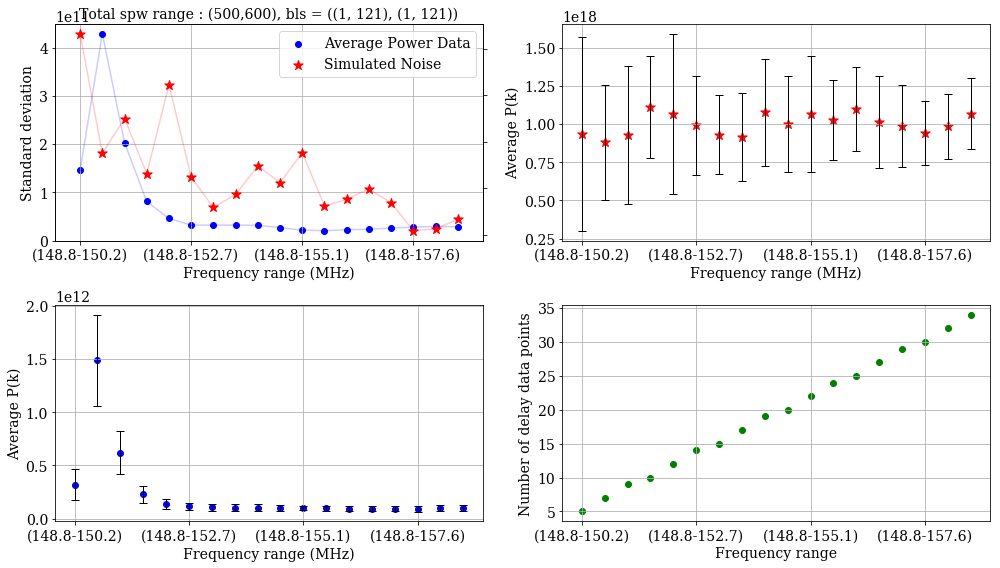

In [15]:
fmin = 500
fmax = 600
spw_jumps = 5
#baselines = [(24,25),(120,121),(67,68),(1,121),(23,25),(53,54),(1,12)]
baselines = [(1,121)]
baselines_SRS = []
for baseline in baselines:
    real_data, null_real_data = Power_Data(baseline,fmin,fmax,spw_jumps)
    
    fig = plt.figure(figsize=(14,8))
    

   
    simulation_data = Simulated_Gaussian_Noise(1000000000,100000,real_data[3])
    Plot_Results(real_data,simulation_data)
    #Plot_Results(null_real_data,simulation_data)
    
    # Fitting with the standard error in the mean function isnt precise enough to rule out which baselines 
    # do not have this behavior. It is commented out for the moment.
    #######################################
    #params, cov = curve_fit(Gaussian_err,real_data[3],real_data[1],p0=[real_data[1][0]])
    #if params[0] == real_data[1][0]:
    #    print("Baseline ",baseline,baseline," status : Fit did not converge.")
    #else:
    #    SRS = np.sum((np.array(Gaussian_err(real_data[3],*params)) - np.array(real_data[1]))**2)
    #    baselines_SRS.append((baseline,baseline,SRS))
    #######################################    
    
#baselines_SRS = sorted(baselines_SRS, key = lambda x: x[2])

#for bsl_srs in baselines_SRS:
#    print("Baseline ",bsl_srs[0],bsl_srs[1]," status : Fit converged, SRS = ",bsl_srs[2])




This cell contains the code for plotting all baselines. The difference from this cell and the previous one is that we are using the Plot_Baseline function instead.

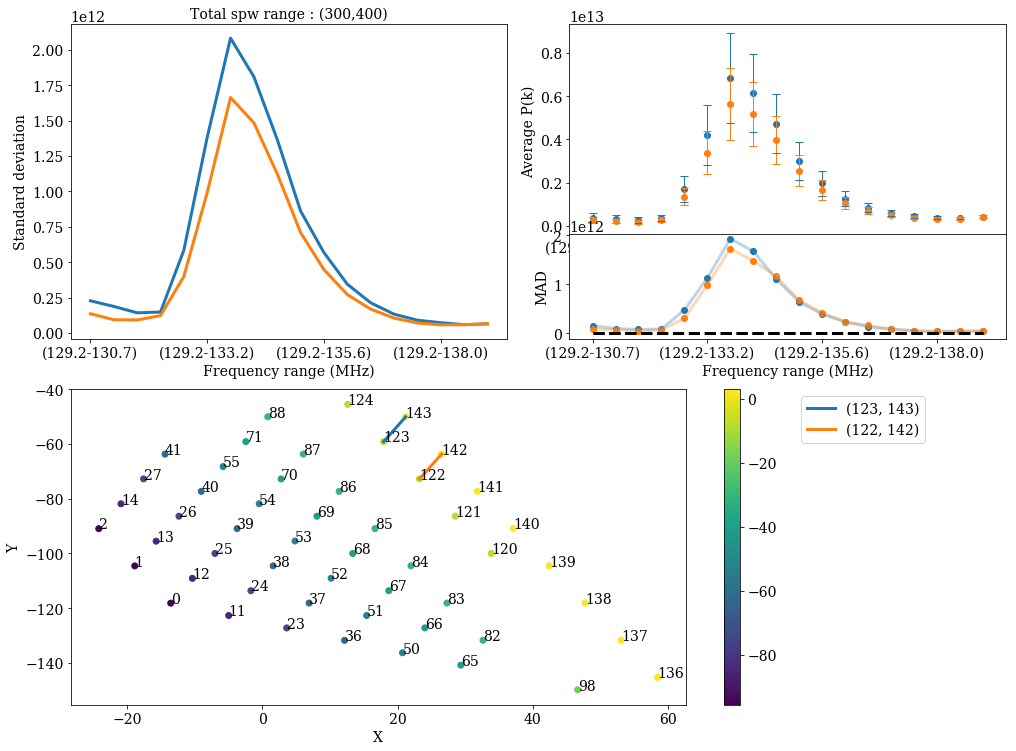

In [17]:
fmin = 300
fmax = 400
spw_jumps = 5
ant_pos = uvd.antenna_positions
ant_num = uvd.antenna_numbers
#baselines = [(24,25),(120,121),(67,68),(1,121),(23,25),(53,54),(1,12),(1,137),(65,140),(40,51),(41,51)]
#baselines = [(1,1),(12,12),(121,121),(120,120),(24,24),(25,25),(67,67),(53,53),(54,54),(68,68)]
#baselines = [(12,141),(13,142)]
#baselines = [(67,68),(1,121),(1,12),(1,137)]
#baselines = [(13,141),(1,121),(14,142),(11,139),(12,140),(2,122),(0,120)]
#baselines = [(84,88),(67,71),(51,55),(36,40),(50,54),(66,70),
#             (83,87),(120,124),(139,143),(27,23),(136,140),
#             (23,27),(82,86),(65,69),(138,142),(37,41),(137,141)]
baselines=[(123,143),(122,142)]
#baselines=[(23,24),(37,38),(52,53),(68,69),(85,86)]
#baselines=[(123,143),(122,142),(121,141),(120,140)]
#baselines = [(84,121),(85,122),(86,123),(87,124)]
#baselines = [(83,84),(66,67),(50,51),(120,121)]
#baselines = [(123,143)]
gs = gspec.GridSpec(2, 6)
gs1 = gspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[0,3:6],hspace=0.0)
fig = plt.figure(figsize=(14,10))
for baseline in baselines:
    real_data, null_real_data = Power_Data(baseline,fmin,fmax,spw_jumps)
    Plot_Baseline(real_data)
    #Plot_Baseline(null_real_data)
    Plot_Bsl_Line(baseline,ant_pos,ant_num)
    plt.legend(baselines,bbox_to_anchor=(1.4, 1), loc=0,fontsize=14)
    
ax = plt.subplot(gs[1, 0:5])
sc = ax.scatter(ant_pos[:,0],ant_pos[:,1],c=ant_pos[:,2])
ax.set_ylabel("Y",fontsize=14)
ax.set_xlabel("X",fontsize=14)
for i, num in enumerate(ant_num):
    ax.annotate(str(num), (ant_pos[i,0], ant_pos[i,1]),fontsize=14)    
plt.colorbar(sc)
plt.show()
#plt.savefig(str(baselines)+"-"+str((fmin,fmax))+".pdf")